In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import cv2
import os
import datetime
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from PIL import ImageEnhance, Image 
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, concatenate, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard, EarlyStopping, Callback
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
import math
import pickle


In [20]:
"""
def load_train_images() :
    n_classes = 43
    data = []
    labels = []
    #Reading the train images
    for itr in range(n_classes) :
        path = 'Train/{0}/'.format(itr)
        Class = os.listdir(path)
        for c in Class :
            image = cv2.imread(path + c)
            image = Image.fromarray(image)
            data.append(np.array(image))
            labels.append(itr)
    data=np.array(data)
    labels=np.array(labels)
    return data, labels
"""

def load_train_images(target_size):
    n_classes = 43
    data = []
    labels = []
    
    # Reading and resizing the train images
    for itr in range(n_classes):
        path = 'Train/{0}/'.format(itr)
        Class = os.listdir(path)
        
        for c in Class:
            image = cv2.imread(path + c)
            image = cv2.resize(image, target_size)  # Resize the image
            data.append(image)
            labels.append(itr)
    
    data = np.array(data)
    labels = np.array(labels)
    
    return data, labels

In [3]:
def randomize_data(data, labels) :
    s=np.arange(data.shape[0])
    np.random.shuffle(s)
    data=data[s]
    labels=labels[s]
    return data, labels

In [4]:
def split_data(data, labels, val_size) :
    
    #Splitting images into train and validation sets
    (X_train, X_val) = data[(int)(val_size*len(labels)):], data[:(int)(val_size*len(labels))]
    
    #Normalization
    X_train = X_train.astype('float32')/255 
    X_val = X_val.astype('float32')/255
    
    #Splitting labels
    (y_train, y_val) = labels[(int)(val_size*len(labels)):], labels[:(int)(val_size*len(labels))]
    
    #Performing OneHotEncoding
    enc = OneHotEncoder()
    enc.fit(y_train.reshape(-1,1))
    
    y_train = enc.transform(y_train.reshape(-1,1))
    y_val = enc.transform(y_val.reshape(-1,1))
    y_train = y_train.toarray()
    y_val = y_val.toarray()
    
    return X_train, X_val, y_train, y_val

In [5]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

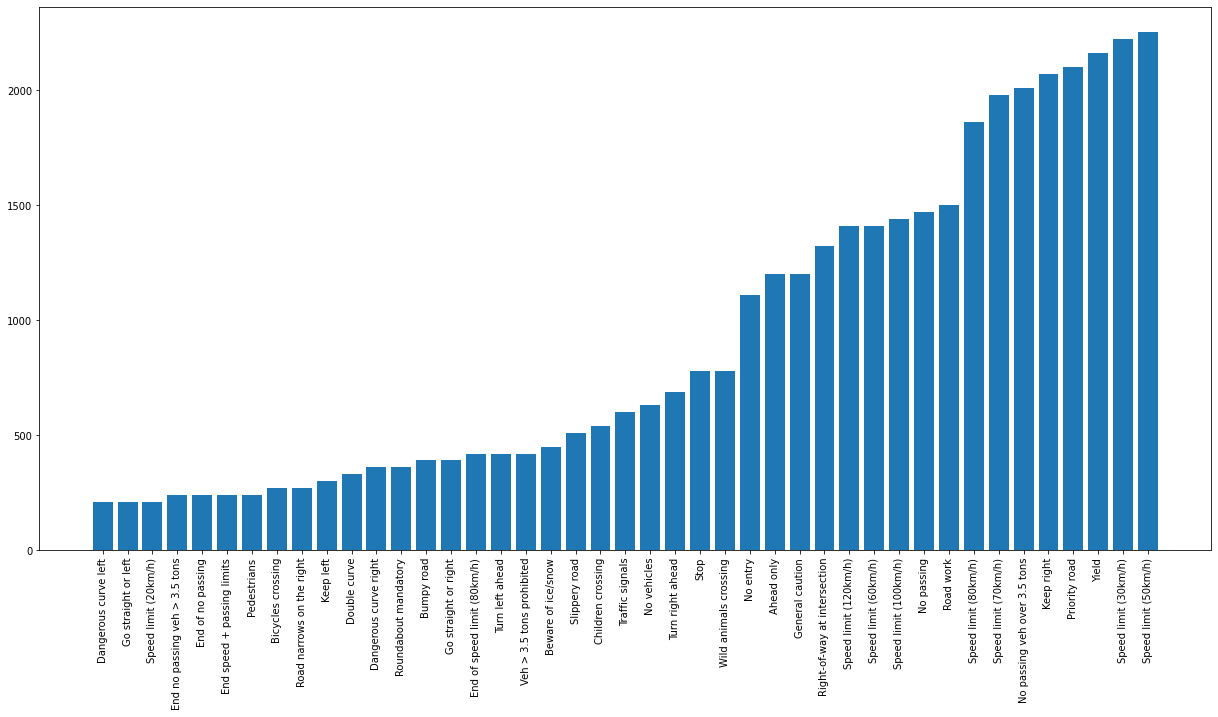

In [6]:
train_path = "Train"
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

In [7]:
import random

In [10]:
import shutil
#Run this only once
#Creating validation directory
val_dir = "C:/Users/Vedant/AI_proj2/data_sets/Validation"
os.mkdir(val_dir)

n_classes = 43
train_dir = "C:/Users/Vedant/AI_proj2/data_sets/Train{0}"

#Moving files from train to validation directory
for n in tqdm(range(n_classes)) :
  path = os.path.join(val_dir, str(n))
  os.mkdir(path)
  src_path = train_dir.format('/' + str(n))
  files = os.listdir(src_path)
  rand_idx = random.sample(range(len(files)), math.ceil(len(files)/4))
  for idx in rand_idx :
    src = src_path + "/" + files[idx]
    shutil.move(src, path)

100%|██████████| 43/43 [00:12<00:00,  3.37it/s]


In [11]:
df_train = pd.read_csv('Train.csv')
labels_train = df_train['ClassId']

df_test = pd.read_csv('Test.csv')
labels_test = df_test['ClassId']
df_train.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [12]:
df_test.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [13]:
print("No of images in train data : {0}".format(df_train.shape[0]))
print("No of images in test data : {0}".format(df_test.shape[0]))

No of images in train data : 39209
No of images in test data : 12630


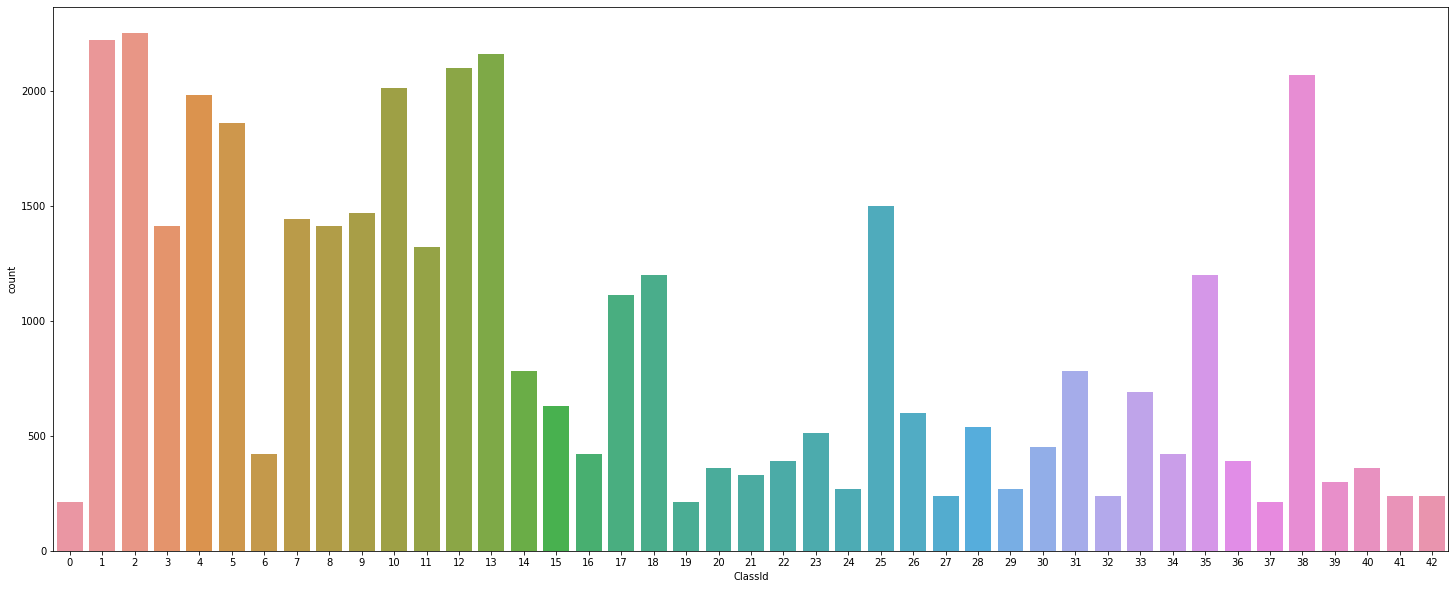

In [14]:
#Checking class distribution in train data
fig, ax = plt.subplots(1, 1)
fig.set_size_inches((25,10))
sns.countplot(data = df_train, x = 'ClassId')
plt.show()

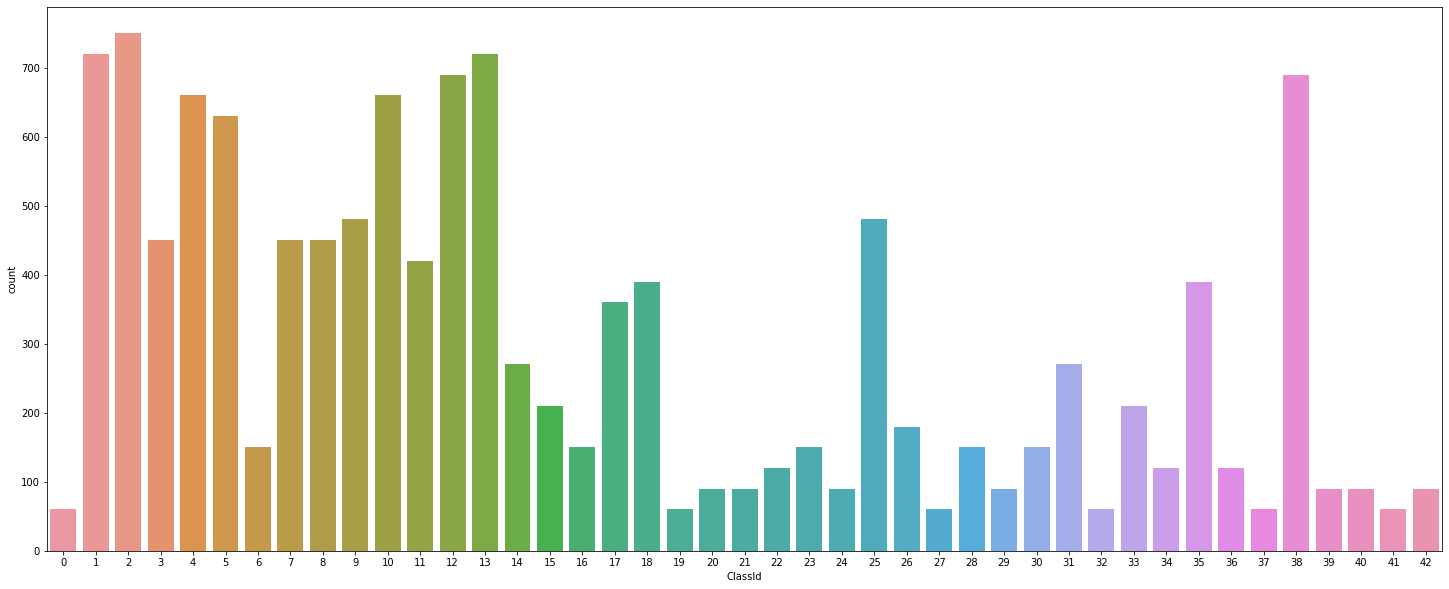

In [15]:
#Checking class distribution in test data
fig, ax = plt.subplots(1, 1)
fig.set_size_inches((25,10))
sns.countplot(data = df_test, x = 'ClassId')
plt.show()

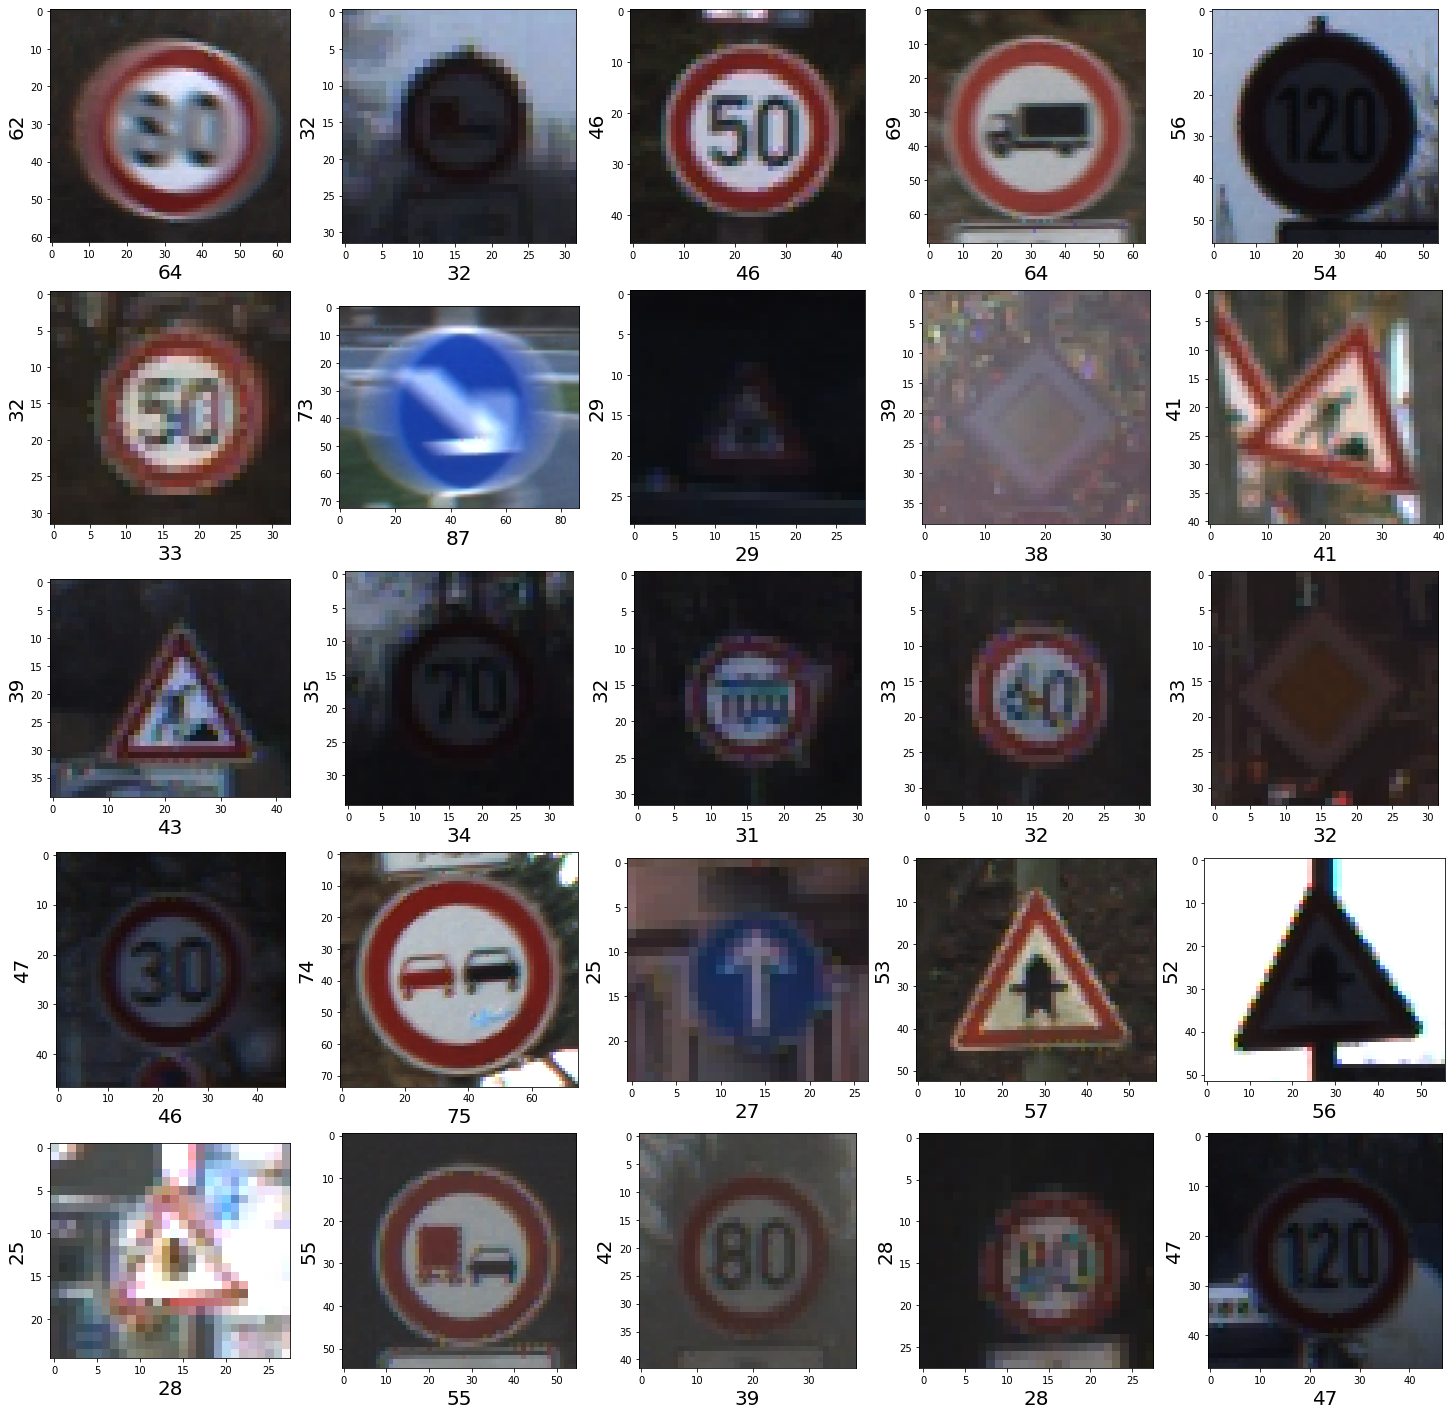

In [18]:
import random
from matplotlib.image import imread

test_file = pd.read_csv('Test.csv')
imgs = test_file["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(False)
    plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

In [21]:
target_size = (128,128)
data, labels = load_train_images(target_size)

(128, 128, 3)


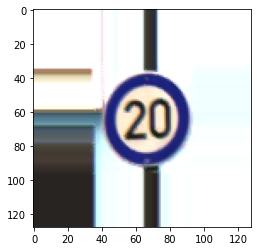

In [22]:
path = 'Train/0/00000_00004_00007.png'
image = cv2.imread(path)
if image.shape[0] <128 :
    diff = 128 - image.shape[0]
    top = math.ceil(diff/2)
    bottom = math.floor(diff/2)
if image.shape[1] <128 :
    diff = 128 - image.shape[1]
    left = math.ceil(diff/2)
    right = math.floor(diff/2)
image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_REPLICATE)
print(image.shape)
image = Image.fromarray(image)
plt.imshow(image)
plt.show()

In [23]:
def padding(image) :
    top, bottom, left, right = 0, 0, 0, 0
    if image.shape[0] < 128 :
        diff = 128 - image.shape[0]
        top = math.ceil(diff/2)
        bottom = math.floor(diff/2)
    if image.shape[1] < 128 :
        diff = 128 - image.shape[1]
        left = math.ceil(diff/2)
        right = math.floor(diff/2)
    image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_REPLICATE)
    return image

def truncate(image) :
    image = image[0:128, 0:128]
    return image

def load_train_images_preprocessed() :
    
    n_classes = 43
    data = []
    labels = []

    #Reading the train images
    for itr in tqdm(range(n_classes)) :
        path = 'Train/{0}/'.format(itr)
        Class = os.listdir(path)

        for c in Class :
            image = cv2.imread(path + c)
            image = padding(image)
            image = truncate(image)
            image = Image.fromarray(image, 'RGB')
            data.append(np.array(image))
            labels.append(itr)
    
    data=np.array(data)
    labels=np.array(labels)
    return data, labels

In [24]:
#Loading the preprocessed images
import random
data_preprocessed, new_labels = load_train_images_preprocessed()

100%|██████████| 43/43 [00:32<00:00,  1.31it/s]


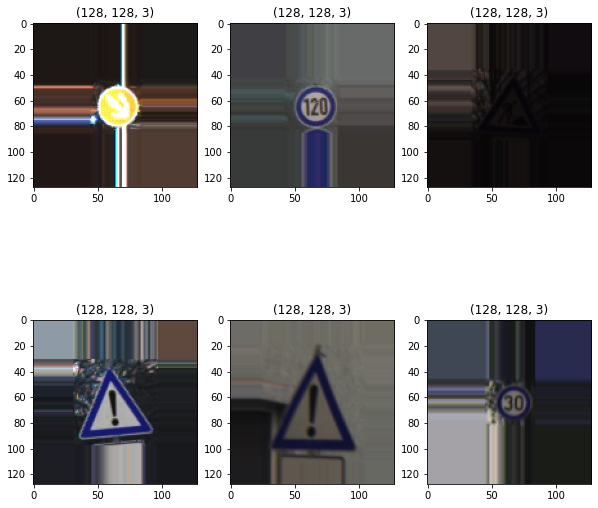

In [25]:
fig, ax = plt.subplots(2,3)
height, width = 10, 10

fig.set_size_inches(height, width)
seed = random.randrange(0, data_preprocessed.shape[0])
ax[0][0].title.set_text(data_preprocessed[seed].shape)
ax[0][0].imshow(data_preprocessed[seed])

fig.set_size_inches(height, width)
seed = random.randrange(0, data_preprocessed.shape[0])
ax[0][1].title.set_text(data_preprocessed[seed].shape)
ax[0][1].imshow(data_preprocessed[seed])

fig.set_size_inches(height, width)
seed = random.randrange(0, data_preprocessed.shape[0])
ax[0][2].title.set_text(data_preprocessed[seed].shape)
ax[0][2].imshow(data_preprocessed[seed])

fig.set_size_inches(height, width)
seed = random.randrange(0, data_preprocessed.shape[0])
ax[1][0].title.set_text(data_preprocessed[seed].shape)
ax[1][0].imshow(data_preprocessed[seed])

fig.set_size_inches(height, width)
seed = random.randrange(0, data_preprocessed.shape[0])
ax[1][1].title.set_text(data_preprocessed[seed].shape)
ax[1][1].imshow(data_preprocessed[seed])

fig.set_size_inches(height, width)
seed = random.randrange(0, data_preprocessed.shape[0])
ax[1][2].title.set_text(data_preprocessed[seed].shape)
ax[1][2].imshow(data_preprocessed[seed])

In [26]:
def channel_count(data) :
    n_channels = []
    ret_dict = {}
    for itr in range(len(data)) :
        img = data[itr]
        if img.ndim == 2 :
            channels = 1
        if img.ndim == 3 :
            channels = img.shape[-1]
        n_channels.append(channels)
    tmp = set(n_channels)
    for ele in tmp :
        ret_dict[ele] = n_channels.count(ele)
    return ret_dict

In [27]:
n_channels = channel_count(data)
for idx, ele in n_channels.items() :
  print("There are {0} {1}-channeled images".format(ele, idx))

There are 39209 3-channeled images


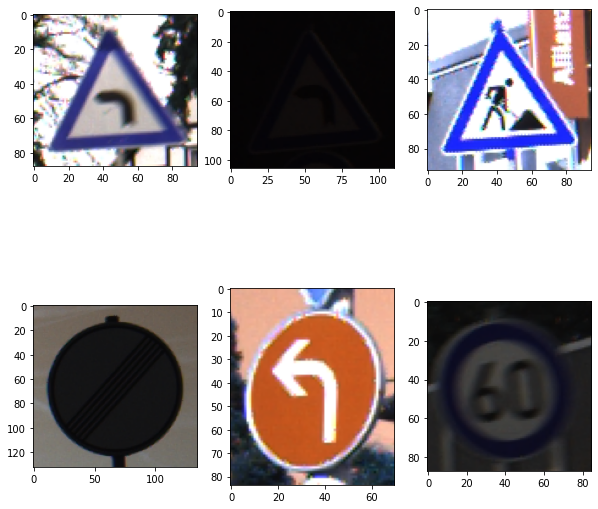

In [28]:
#Dealing with bright and dark images :

height, width = 10, 10
fig, ax = plt.subplots(2,3)
fig.set_size_inches(height, width)
image = cv2.imread("Train/19/00019_00003_00027.png")
image = Image.fromarray(image)
ax[0][0].imshow(image)
fig.set_size_inches(height, width)
image = cv2.imread("Train/19/00019_00004_00029.png")
image = Image.fromarray(image)
ax[0][1].imshow(image)
fig.set_size_inches(height, width)
image = cv2.imread("Train/25/00025_00000_00026.png")
image = Image.fromarray(image)
ax[0][2].imshow(image)
fig.set_size_inches(height, width)
image = cv2.imread("Train/32/00032_00000_00029.png")
image = Image.fromarray(image)
ax[1][0].imshow(image)
fig.set_size_inches(height, width)
image = cv2.imread("Train/34/00034_00000_00028.png")
image = Image.fromarray(image)
ax[1][1].imshow(image)
fig.set_size_inches(height, width)
image = cv2.imread("Train/3/00003_00000_00028.png")
image = Image.fromarray(image)
ax[1][2].imshow(image)

In [29]:
#Using Data Augmentation
im = Image.open('Train/19/00019_00004_00029.png')
enhancer = ImageEnhance.Brightness(im)
enhanced_im1 = enhancer.enhance(10)
im = Image.open("Train/32/00032_00000_00029.png")
enhancer = ImageEnhance.Brightness(im)
enhanced_im2 = enhancer.enhance(10)

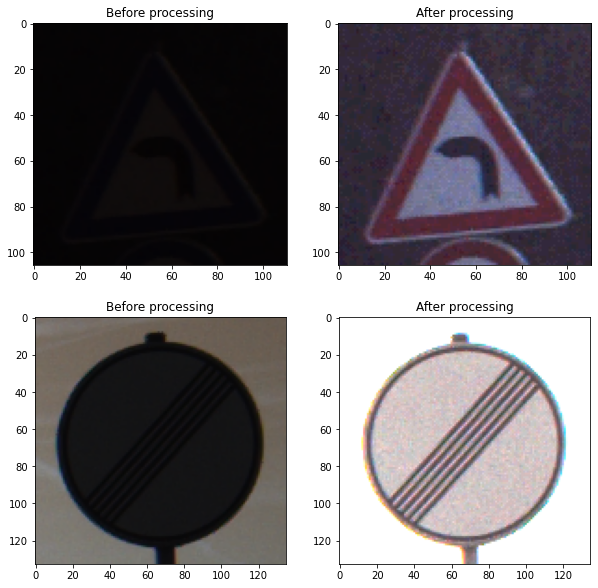

In [25]:
height, width = 10, 10
fig, ax = plt.subplots(2,2)
fig.set_size_inches(height, width)

image = cv2.imread('Train/19/00019_00004_00029.png')
image = Image.fromarray(image)
ax[0][0].title.set_text('Before processing')
ax[0][0].imshow(image)
ax[0][1].title.set_text('After processing')
ax[0][1].imshow(enhanced_im1)

image = cv2.imread("Train/32/00032_00000_00029.png")
image = Image.fromarray(image)
ax[1][0].title.set_text('Before processing')
ax[1][0].imshow(image)
ax[1][1].title.set_text('After processing')
ax[1][1].imshow(enhanced_im2)

In [30]:
data = []
labels = []
classes = 43

for i in range(classes):
    path = os.path.join(os.getcwd(),'Train',str(i))
    images = os.listdir(path)
    
    for j in images:
        try:
            image = Image.open(path + '\\'+ j)
            image = image.resize((30,30))
            image = np.array(image)
            data.append(image)
            labels.append(i)
        except:
            print("Error loading image")

In [31]:
data = np.array(data)
labels = np.array(labels)

In [32]:
print(data.shape, labels.shape)

(39209, 30, 30, 3) (39209,)


In [33]:
data[39000]

array([[[17, 17, 19],
        [18, 18, 19],
        [18, 17, 18],
        ...,
        [20, 19, 23],
        [21, 19, 21],
        [21, 20, 21]],

       [[17, 19, 23],
        [18, 19, 20],
        [19, 19, 20],
        ...,
        [22, 21, 22],
        [24, 23, 24],
        [21, 21, 22]],

       [[20, 24, 26],
        [16, 18, 20],
        [17, 18, 20],
        ...,
        [20, 19, 21],
        [21, 20, 21],
        [19, 19, 19]],

       ...,

       [[20, 20, 25],
        [19, 19, 24],
        [19, 18, 23],
        ...,
        [30, 28, 32],
        [19, 22, 27],
        [18, 19, 24]],

       [[19, 19, 24],
        [17, 17, 22],
        [18, 17, 22],
        ...,
        [22, 26, 31],
        [18, 25, 31],
        [18, 24, 31]],

       [[16, 17, 21],
        [16, 16, 20],
        [17, 16, 21],
        ...,
        [46, 56, 74],
        [43, 54, 73],
        [42, 53, 73]]], dtype=uint8)

In [34]:
labels[4900]

3

In [51]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=68) # 0.25 x 0.8 = 0.2

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=68) # 0.25 x 0.8 = 0.2

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape,X_val.shape,y_val.shape)

(31367, 30, 30, 3) (7842, 30, 30, 3) (31367,) (7842,)
(25093, 30, 30, 3) (7842, 30, 30, 3) (25093,) (7842,) (6274, 30, 30, 3) (6274,)


In [52]:
from tensorflow.keras.utils import to_categorical
#Converting the labels into one hot encoding
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val  = to_categorical(y_val, 43)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(25093, 30, 30, 3) (7842, 30, 30, 3) (25093, 43) (7842, 43)


In [37]:
X_train.shape[1:]

(30, 30, 3)

In [38]:
y_train[20000]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

<h1> 1. CNN with 1 Convolutional Layer

In [53]:
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential, load_model
from keras.optimizers import adam_v2
print(X_train.shape[1:])
input_shape = X_train.shape[1:]

def CNN1(): 
    cnn1 = Sequential()
    cnn1.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    cnn1.add(MaxPooling2D(pool_size=(2, 2)))
    cnn1.add(Dropout(0.2))

    cnn1.add(Flatten())

    cnn1.add(Dense(256, activation='relu'))
    cnn1.add(Dense(43, activation='softmax'))

    cnn1.compile(adam_v2.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return cnn1

(30, 30, 3)


In [40]:
print(os.getcwd())

C:\Users\Vedant\AI_proj2


In [54]:
cnn1 = CNN1()

In [55]:
cnn1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 flatten_2 (Flatten)         (None, 6272)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               1605888   
                                                                 
 dense_5 (Dense)             (None, 43)                11051     
                                                      

In [56]:
#Final trainig of model
tf.debugging.disable_traceback_filtering()
history1 = cnn1.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val))

warnings.filterwarnings("ignore", category=DeprecationWarning)

Epoch 1/20
785/785 [==============================] - 18s 23ms/step - loss: 3.1133 - accuracy: 0.6949 - val_loss: 0.5642 - val_accuracy: 0.8527
Epoch 2/20
785/785 [==============================] - 17s 22ms/step - loss: 0.4275 - accuracy: 0.8932 - val_loss: 0.3283 - val_accuracy: 0.9201
Epoch 3/20
785/785 [==============================] - 18s 23ms/step - loss: 0.3150 - accuracy: 0.9256 - val_loss: 0.4196 - val_accuracy: 0.9099
Epoch 4/20
785/785 [==============================] - 17s 22ms/step - loss: 0.3145 - accuracy: 0.9268 - val_loss: 0.2941 - val_accuracy: 0.9415
Epoch 5/20
785/785 [==============================] - 17s 21ms/step - loss: 0.2320 - accuracy: 0.9456 - val_loss: 0.4376 - val_accuracy: 0.9291
Epoch 6/20
785/785 [==============================] - 17s 22ms/step - loss: 0.2910 - accuracy: 0.9355 - val_loss: 0.4414 - val_accuracy: 0.9163
Epoch 7/20
785/785 [==============================] - 18s 23ms/step - loss: 0.2435 - accuracy: 0.9506 - val_loss: 0.4477 - val_accuracy:

In [57]:
cnn1.save_weights(r"C:\Users\Vedant\AI_proj2\BestScoreCNN1.h5")

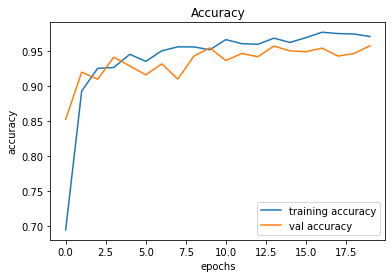

In [58]:
#plotting graphs for accuracy 
plt.figure(0)
plt.plot(history1.history['accuracy'], label='training accuracy')
plt.plot(history1.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

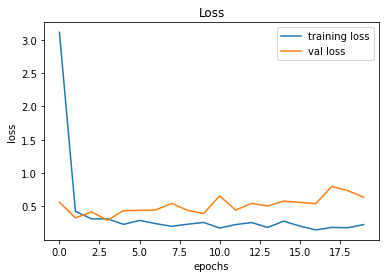

In [59]:
#plotting graphs for loss 
plt.figure(1)
plt.plot(history1.history['loss'], label='training loss')
plt.plot(history1.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

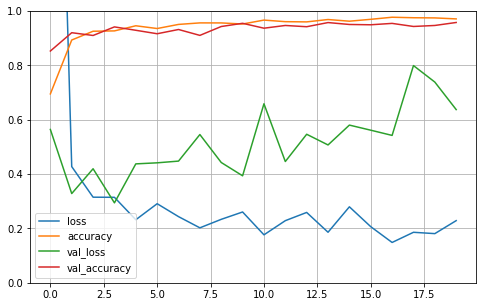

In [60]:
pd.DataFrame(history1.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [61]:
score = cnn1.evaluate(X_test, y_test, verbose=0)

print('Test Score:', score[0])
print('Test Accuracy:', score[1])

Test Score: 0.6548086404800415
Test Accuracy: 0.9537107944488525


<h1> 2. CNN with 3 Convolutional Layer

In [62]:
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential, load_model
from keras.optimizers import adam_v2

input_shape = X_train.shape[1:]

def CNN3():
    cnn3 = Sequential()
    cnn3.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    cnn3.add(MaxPooling2D((2, 2)))
    cnn3.add(Dropout(0.25))

    cnn3.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    cnn3.add(MaxPooling2D(pool_size=(2, 2)))
    cnn3.add(Dropout(0.25))

    cnn3.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    cnn3.add(Dropout(0.4))

    cnn3.add(Flatten())

    cnn3.add(Dense(256, activation='relu'))
    cnn3.add(Dropout(0.3))
    cnn3.add(Dense(43, activation='softmax'))
    
    cnn3.compile(adam_v2.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    
    return cnn3

In [63]:
cnn3 = CNN3()

In [44]:
cnn3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 6, 6, 64)         

In [64]:
#Final trainig of model
history2 = cnn3.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val))

warnings.filterwarnings("ignore", category=DeprecationWarning)

Epoch 1/20
785/785 [==============================] - 31s 39ms/step - loss: 2.5497 - accuracy: 0.3966 - val_loss: 0.5865 - val_accuracy: 0.8441
Epoch 2/20
785/785 [==============================] - 30s 38ms/step - loss: 0.8033 - accuracy: 0.7583 - val_loss: 0.2705 - val_accuracy: 0.9265
Epoch 3/20
785/785 [==============================] - 28s 35ms/step - loss: 0.5415 - accuracy: 0.8389 - val_loss: 0.1854 - val_accuracy: 0.9493
Epoch 4/20
785/785 [==============================] - 28s 36ms/step - loss: 0.4611 - accuracy: 0.8633 - val_loss: 0.1867 - val_accuracy: 0.9476
Epoch 5/20
785/785 [==============================] - 28s 36ms/step - loss: 0.4136 - accuracy: 0.8799 - val_loss: 0.1130 - val_accuracy: 0.9704
Epoch 6/20
785/785 [==============================] - 28s 36ms/step - loss: 0.3754 - accuracy: 0.8892 - val_loss: 0.1055 - val_accuracy: 0.9713
Epoch 7/20
785/785 [==============================] - 28s 36ms/step - loss: 0.3862 - accuracy: 0.8910 - val_loss: 0.1124 - val_accuracy:

In [66]:
cnn3.save_weights("C:/Users/Vedant/AI_proj2/BestScoreCNN3.h5")

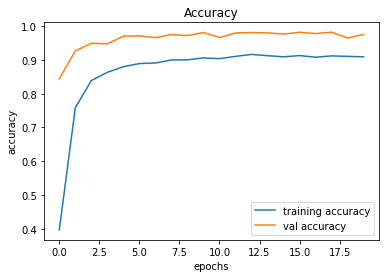

In [67]:
#plotting graphs for accuracy 
plt.figure(0)
plt.plot(history2.history['accuracy'], label='training accuracy')
plt.plot(history2.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

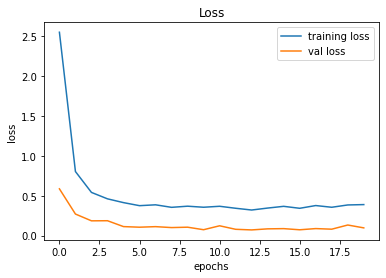

In [68]:
#plotting graphs for loss 
plt.figure(1)
plt.plot(history2.history['loss'], label='training loss')
plt.plot(history2.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

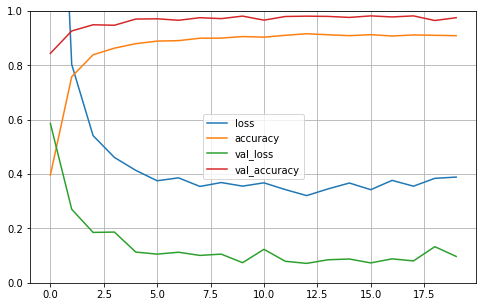

In [69]:
pd.DataFrame(history2.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [70]:
score = cnn3.evaluate(X_test, y_test, verbose=0)

print('Test Score:', score[0])
print('Test Accuracy:', score[1])

Test Score: 0.08910571038722992
Test Accuracy: 0.9769191741943359


<h1> 3. CNN with 4 Convolutional Layer

In [71]:
from tensorflow.keras.models import Sequential, load_model
from keras.optimizers import adam_v2

input_shape = X_train.shape[1:]

#Building the model
def CNN4():
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=input_shape))
    model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.25))
    
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.25))
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(43, activation='softmax'))

    warnings.filterwarnings("ignore", category=DeprecationWarning)
    model.compile(adam_v2.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [72]:
cnn4 = CNN4()

In [74]:
cnn4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 26, 26, 32)        2432      
                                                                 
 conv2d_7 (Conv2D)           (None, 22, 22, 32)        25632     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 11, 11, 32)       0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 11, 11, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 9, 9, 64)          18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 7, 7, 64)          36928     
                                                      

In [75]:
#Final trainig of model
history3 = cnn4.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val))

warnings.filterwarnings("ignore", category=DeprecationWarning)

Epoch 1/20
785/785 [==============================] - 40s 50ms/step - loss: 2.0369 - accuracy: 0.4892 - val_loss: 0.3861 - val_accuracy: 0.9066
Epoch 2/20
785/785 [==============================] - 40s 50ms/step - loss: 0.5811 - accuracy: 0.8325 - val_loss: 0.1729 - val_accuracy: 0.9544
Epoch 3/20
785/785 [==============================] - 49s 62ms/step - loss: 0.3783 - accuracy: 0.8938 - val_loss: 0.1147 - val_accuracy: 0.9680
Epoch 4/20
785/785 [==============================] - 41s 53ms/step - loss: 0.2838 - accuracy: 0.9193 - val_loss: 0.0853 - val_accuracy: 0.9780
Epoch 5/20
785/785 [==============================] - 41s 53ms/step - loss: 0.2382 - accuracy: 0.9342 - val_loss: 0.0833 - val_accuracy: 0.9783
Epoch 6/20
785/785 [==============================] - 42s 53ms/step - loss: 0.2425 - accuracy: 0.9338 - val_loss: 0.0726 - val_accuracy: 0.9812
Epoch 7/20
785/785 [==============================] - 42s 53ms/step - loss: 0.2321 - accuracy: 0.9391 - val_loss: 0.1254 - val_accuracy:

In [100]:
# cnn4.save_weights("C:/Users/Vedant/AI_proj2/OwnBestScoreforCNN4.h5")

!mkdir -p saved_models
cnn4.save('saved_models/OwnBestScoreforCNN4')

INFO:tensorflow:Assets written to: saved_models/OwnBestScoreforCNN4\assets


INFO:tensorflow:Assets written to: saved_models/OwnBestScoreforCNN4\assets


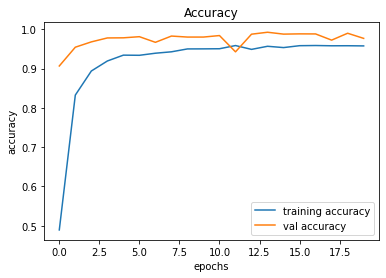

In [77]:
#plotting graphs for accuracy 
plt.figure(0)
plt.plot(history3.history['accuracy'], label='training accuracy')
plt.plot(history3.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

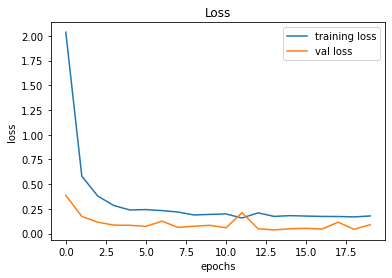

In [78]:
#plotting graphs for loss 
plt.figure(1)
plt.plot(history3.history['loss'], label='training loss')
plt.plot(history3.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

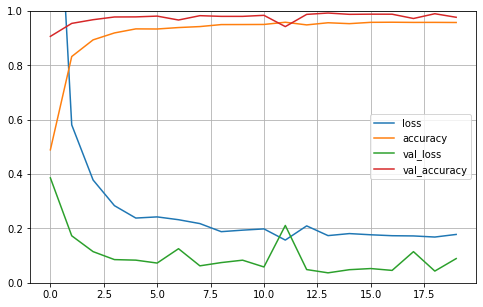

In [79]:
pd.DataFrame(history3.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [80]:
score = cnn4.evaluate(X_test, y_test, verbose=0)

print('Test Score:', score[0])
print('Test Accuracy:', score[1])

Test Score: 0.09408707171678543
Test Accuracy: 0.9739862084388733


<h1> Creating a Better 4 Dimentional CNN

In [81]:
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential, load_model
from keras.optimizers import adam_v2

input_shape = X_train.shape[1:]

def CNN4_model():
    
    cnn4 = Sequential()
    cnn4.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    cnn4.add(BatchNormalization())

    cnn4.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    cnn4.add(BatchNormalization())
    cnn4.add(MaxPooling2D(pool_size=(2, 2)))
    cnn4.add(Dropout(0.25))

    cnn4.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    cnn4.add(BatchNormalization())
    cnn4.add(Dropout(0.25))

    cnn4.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    cnn4.add(BatchNormalization())
    cnn4.add(MaxPooling2D(pool_size=(2, 2)))
    cnn4.add(Dropout(0.25))

    cnn4.add(Flatten())

    cnn4.add(Dense(512, activation='relu'))
    cnn4.add(BatchNormalization())
    cnn4.add(Dropout(0.5))

    cnn4.add(Dense(256, activation='relu'))
    cnn4.add(BatchNormalization())
    cnn4.add(Dropout(0.5))

    cnn4.add(Dense(43, activation='softmax'))
    
    cnn4.compile(adam_v2.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return cnn4

In [82]:
cnn4_1 = CNN4_model()

In [83]:
cnn4_1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 28, 28, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_11 (Conv2D)          (None, 26, 26, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 26, 26, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                      

In [84]:
#Final trainig of model
history4 = cnn4_1.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val))

warnings.filterwarnings("ignore", category=DeprecationWarning)

Epoch 1/20
785/785 [==============================] - 46s 57ms/step - loss: 1.3259 - accuracy: 0.6513 - val_loss: 0.1217 - val_accuracy: 0.9680
Epoch 2/20
785/785 [==============================] - 53s 68ms/step - loss: 0.2393 - accuracy: 0.9299 - val_loss: 0.0676 - val_accuracy: 0.9853
Epoch 3/20
785/785 [==============================] - 49s 63ms/step - loss: 0.1434 - accuracy: 0.9566 - val_loss: 0.0823 - val_accuracy: 0.9798
Epoch 4/20
785/785 [==============================] - 52s 67ms/step - loss: 0.0985 - accuracy: 0.9704 - val_loss: 0.0428 - val_accuracy: 0.9884
Epoch 5/20
785/785 [==============================] - 55s 70ms/step - loss: 0.0894 - accuracy: 0.9732 - val_loss: 0.0358 - val_accuracy: 0.9933
Epoch 6/20
785/785 [==============================] - 52s 66ms/step - loss: 0.0776 - accuracy: 0.9775 - val_loss: 0.0331 - val_accuracy: 0.9904
Epoch 7/20
785/785 [==============================] - 53s 68ms/step - loss: 0.0900 - accuracy: 0.9725 - val_loss: 0.1471 - val_accuracy:

In [101]:
# cnn4_1.save_weights("C:/Users/Vedant/AI_proj2/BestScoreCNN4.h5")


cnn4_1.save('saved_models/BestScoreCNN4')

INFO:tensorflow:Assets written to: saved_models/BestScoreCNN4\assets


INFO:tensorflow:Assets written to: saved_models/BestScoreCNN4\assets


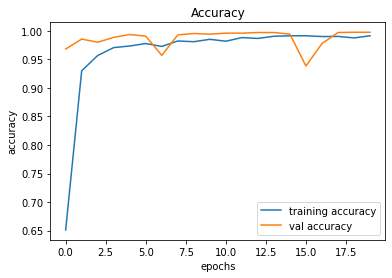

In [86]:
#plotting graphs for accuracy 
plt.figure(0)
plt.plot(history4.history['accuracy'], label='training accuracy')
plt.plot(history4.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

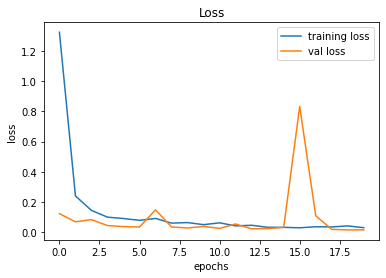

In [87]:
#plotting graphs for loss 
plt.figure(1)
plt.plot(history4.history['loss'], label='training loss')
plt.plot(history4.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

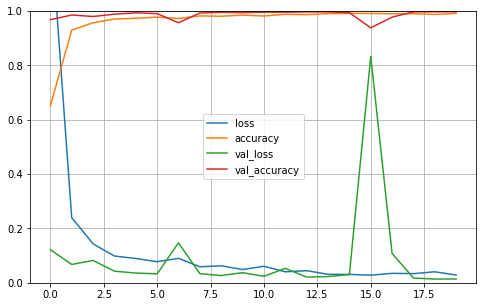

In [88]:
pd.DataFrame(history4.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [89]:
score = cnn4_1.evaluate(X_test, y_test, verbose=0)

print('Test Score:', score[0])
print('Test Accuracy:', score[1])

Test Score: 0.010260753333568573
Test Accuracy: 0.9977046847343445


In [92]:
test_df = pd.read_csv("Test.csv")

test_df = test_df[['Path', 'Width', 'Height', 'ClassId', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2']]

for itr in tqdm(range(test_df.shape[0])) :
    test_df.iloc[itr, 0] = "Prediction/" + test_df.iloc[itr, 0]
    test_df.iloc[itr, 3] += 1

test_df = test_df.rename(columns={'Path' : 'Path',
                                  'Width' : 'Width',
                                  'Height' : 'Height',
                                  'ClassId' : 'Class',
                                  'Roi.X1' : 'Roi.X1', 
                                  'Roi.Y1' : 'Roi.Y1',
                                  'Roi.X2' : 'Roi.X2',
                                  'Roi.Y2' : 'Roi.Y2'})

test_df.to_csv("C:/Users/Vedant/AI_proj2/test_labels.csv")

100%|██████████| 12630/12630 [00:01<00:00, 8540.72it/s]


## Load our model and try the results

In [105]:
from keras.models import load_model
new_model = load_model('saved_models/BestScoreCNN4')


In [106]:
# Classes of trafic signs
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

In [108]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def test_on_img(img):
    data=[]
    image = Image.open(img)
    image = image.resize((30,30))
    data.append(np.array(image))
    X_test=np.array(data)
#     Y_pred = model.predict_classes(X_test)
    Y_pred= new_model.predict(X_test) 
    classes=np.argmax(Y_pred,axis=1)
    return image,classes

1/1 [==============================] - 0s 40ms/step
Predicted traffic sign is:  Ahead only


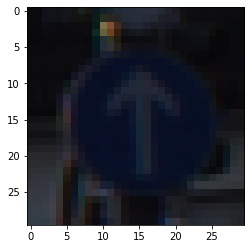

In [111]:
plot, prediction = test_on_img("C:/Users/Vedant/AI_proj2/Test/03100.png")
s = [str(i) for i in prediction]
a = int("".join(s))
print("Predicted traffic sign is: ", classes[a])
plt.imshow(plot)
plt.show()

<h1> Lets visualize now how the models has been training till now 

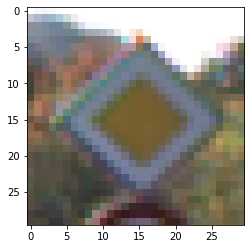

In [93]:
test_im1 = X_train[100]
plt.imshow(test_im1.reshape(30,30,3), cmap='viridis', interpolation='none')
plt.show()

1/1 [==============================] - 0s 140ms/step


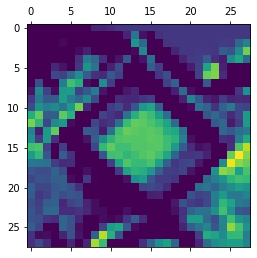

In [94]:
from keras import models
# extracts the outputs of the top 8 layers
layer_outputs = [layer.output for layer in cnn4_1.layers[:8]]

# creates a model that will return these outputs, given the model input
activation_model = models.Model(cnn4_1.input, layer_outputs)

# returns a list of Numpy arrays: one array per layer activation
activations = activation_model.predict(test_im1.reshape(1,30,30,3))

# activation of the 1st convolution layer
first_layer_activation = activations[0]

# display the 4th channel of the activation of the 1st layer of the original model
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

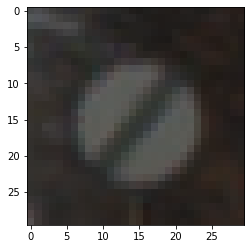

In [95]:
test_im1 = X_train[500]
plt.imshow(test_im1.reshape(30,30,3), cmap='viridis', interpolation='none')
plt.show()

1/1 [==============================] - 0s 26ms/step


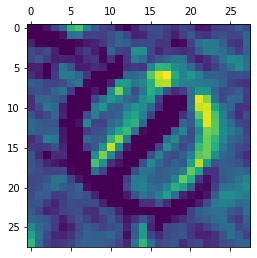

In [96]:
activations = activation_model.predict(test_im1.reshape(1,30,30,3))
first_layer_activation = activations[0]
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

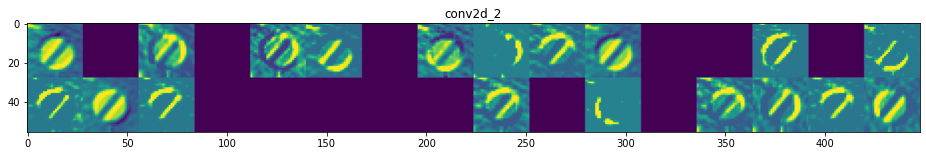

In [97]:
layer_names = []
for layer in cnn1.layers[:-1]:
    layer_names.append(layer.name) 
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    if layer_name.startswith('conv'):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:, :, col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

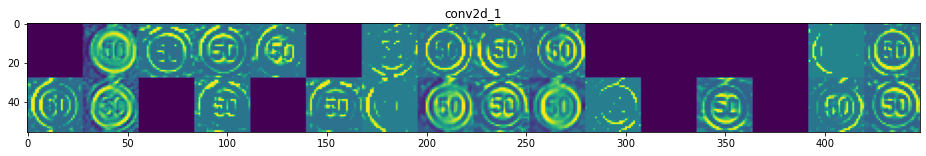

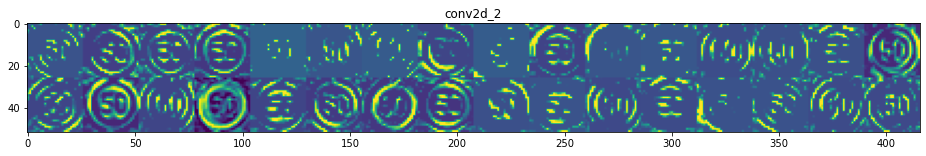

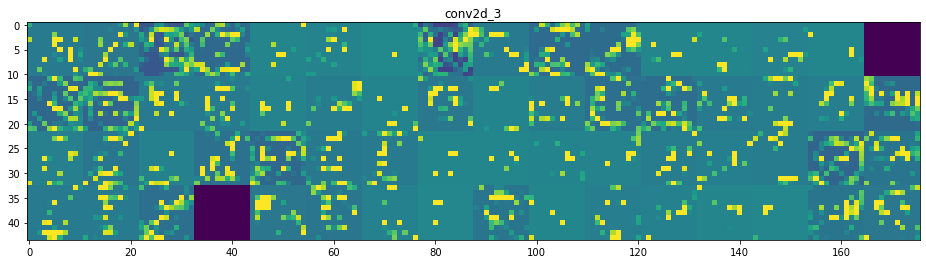

In [92]:
layer_names = []
for layer in cnn3.layers[:-1]:
    layer_names.append(layer.name) 
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    if layer_name.startswith('conv'):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:, :, col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

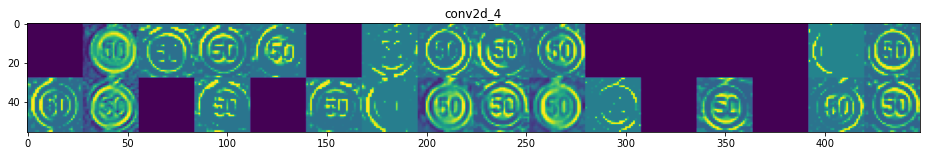

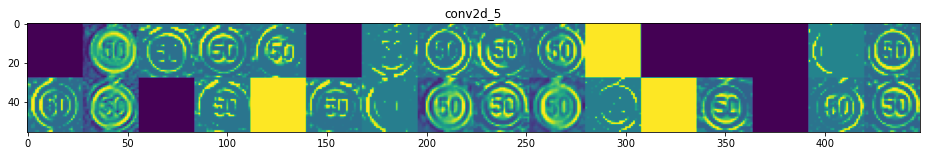

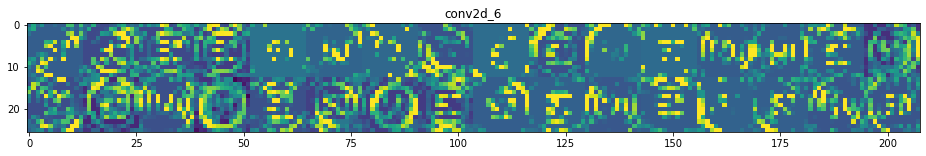

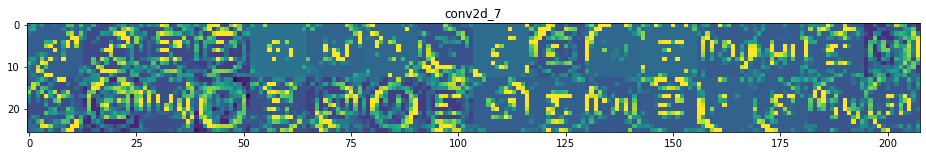

In [93]:
layer_names = []
for layer in cnn4.layers[:-1]:
    layer_names.append(layer.name) 
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    if layer_name.startswith('conv'):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:, :, col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

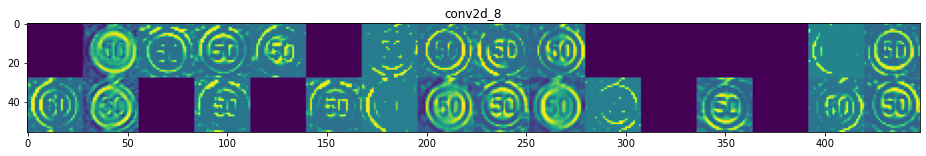

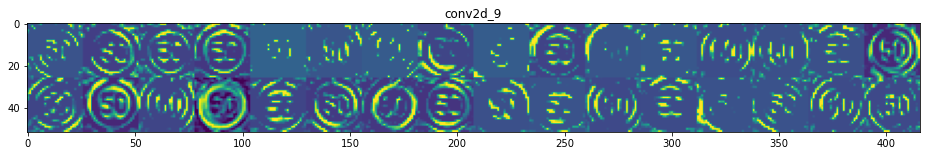

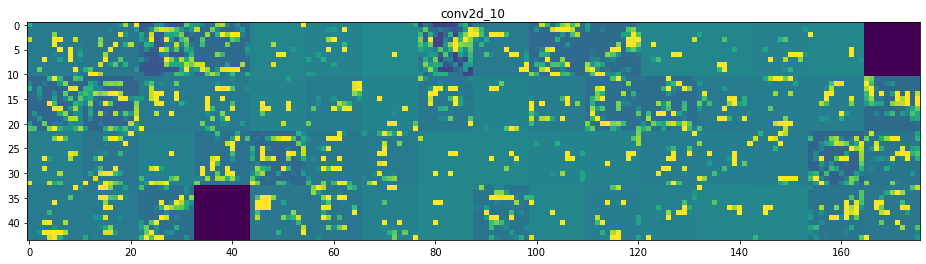

In [94]:
layer_names = []
for layer in cnn4_1.layers[:-1]:
    layer_names.append(layer.name) 
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    if layer_name.startswith('conv'):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:, :, col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')